# Compare single step prediction between

* Baseline = tp0
* tp0 using a single initial condition rather than two

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import jax
from tqdm.notebook import tqdm

from graphufs.datasets import Dataset
from graphufs.batchloader import BatchLoader

from graphufs.utils import get_last_input_mapping, swap_dims

from config import SICTester, TICTester
from prototypes.tp0.config import TP0Tester

/home/tsmith/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [2]:
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [4]:
from functools import partial
import haiku as hk

from graphcast import rollout

from graphufs import construct_wrapped_graphcast
from graphufs.inference import swap_batch_time_dims

In [5]:
def predict(
    emulator,
    dataset,
    idx=0,
    ckpt_id=None,
) -> xr.Dataset:

    ckpt_id = emulator.num_epochs if ckpt_id is None else ckpt_id
    params, state = emulator.load_checkpoint(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    all_predictions = []
    all_targets = []
    for idx in tqdm(range(10)):
        inputs, targets, forcings = dataset.get_xarrays(idx)
        inputs.load()
        targets.load()
        forcings.load()
    
        # retrieve and drop t0
        inittimes = inputs.datetime.isel(time=-1).values
        inputs = inputs.drop_vars("datetime")
        targets = targets.drop_vars("datetime")
        forcings = forcings.drop_vars("datetime")
    
        predictions = rollout.chunked_prediction(
            gc,
            rng=jax.random.PRNGKey(0),
            inputs=inputs,
            targets_template=np.nan * targets,
            forcings=forcings,
        )
    
        # Add t0 as new variable, and swap out for logical sample/batch index
        predictions = swap_batch_time_dims(predictions, inittimes)
        targets = swap_batch_time_dims(targets, inittimes)
        all_predictions.append(predictions)
        all_targets.append(targets)

    all_predictions = xr.concat(all_predictions, dim="time")
    all_targets = xr.concat(all_targets, dim="time")

    return all_predictions, all_targets

In [6]:
experiments = {}
for Emulator, label in zip(
    [SICTester, TP0Tester, TICTester],
    ["1 IC", "2 IC", "3 IC"],
):
    stuff = dict()
    stuff["emulator"] = Emulator()
    stuff["dataset"] = Dataset(stuff["emulator"], mode="validation")
    stuff["predictions"], stuff["targets"] = predict(
        emulator=stuff["emulator"],
        dataset=stuff["dataset"],
    )
    experiments[label] = stuff

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

### Snapshots

In [7]:
tkw = lambda ax: dict(ha="left", va="center", backgroundcolor="white", transform=ax.transAxes)

In [8]:
def make_plot(vlist):
    nrows = 4
    ncols = len(vlist)
    fig, axs = plt.subplots(nrows, len(vlist), figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True, sharey=True)
    
    ilevel = 0
    itime = 1
    ilead = -1

    output_transforms = experiments["2 IC"]["emulator"].output_transforms
    
    for v, ax in zip(vlist, axs[1]):
        plotme = experiments["2 IC"]["targets"][v].isel(lead_time=ilead, time=itime).squeeze()
        if "level" in plotme.dims:
            plotme = plotme.isel(level=ilevel, drop=True)
        if v in output_transforms:
            plotme = output_transforms[v](plotme)
        plotme.plot(ax=ax, cbar_kwargs={"label": ""})
        ax.set(
            xlabel="",
            ylabel="Target" if ax.get_subplotspec().is_first_col() else "",
            title=v if ax.get_subplotspec().is_first_row() else "",
        )
    
    plotlist = {k : list() for k in vlist}

    for key, axr in zip(["2 IC", "3 IC"], [axs[0], axs[2]]):

        for v, ax in zip(vlist, axr):
            plotme = experiments[key]["predictions"][v].isel(lead_time=ilead, time=itime).squeeze()
            target = experiments[key]["targets"][v].isel(lead_time=ilead, time=itime).squeeze()
            if "level" in plotme.dims:
                plotme = plotme.isel(level=ilevel, drop=True)
                target = target.isel(level=ilevel, drop=True)
                
            if v in output_transforms:
                plotme = output_transforms[v](plotme)
                target = output_transforms[v](target)
    
            plotlist[v].append(plotme)
            mae = np.abs(plotme - target).mean().values
            plotme.plot(ax=ax, cbar_kwargs={"label": ""})
            ax.set(
                xlabel="",
                ylabel=key if ax.get_subplotspec().is_first_col() else "",
                title=v if ax.get_subplotspec().is_first_row() else "",
            )
            ax.text(.15, .1, f"MAE = {mae:1.1e}", **tkw(ax))
            if "spfh" in v:
                ngz = (plotme<0).sum().values
                tot = int(len(plotme.lat) * len(plotme.lon))
                ax.text(.15, .9, f"{ngz} / {tot} < 0", **tkw(ax))
    for v, ax in zip(vlist, axs[-1]):
        diff = plotlist[v][1] - plotlist[v][0]
        diff.plot(ax=ax)
        ax.set(
            xlabel="",
            ylabel="row3 - row1" if ax.get_subplotspec().is_first_col() else "",
            title="",
        )
    return fig, axs 

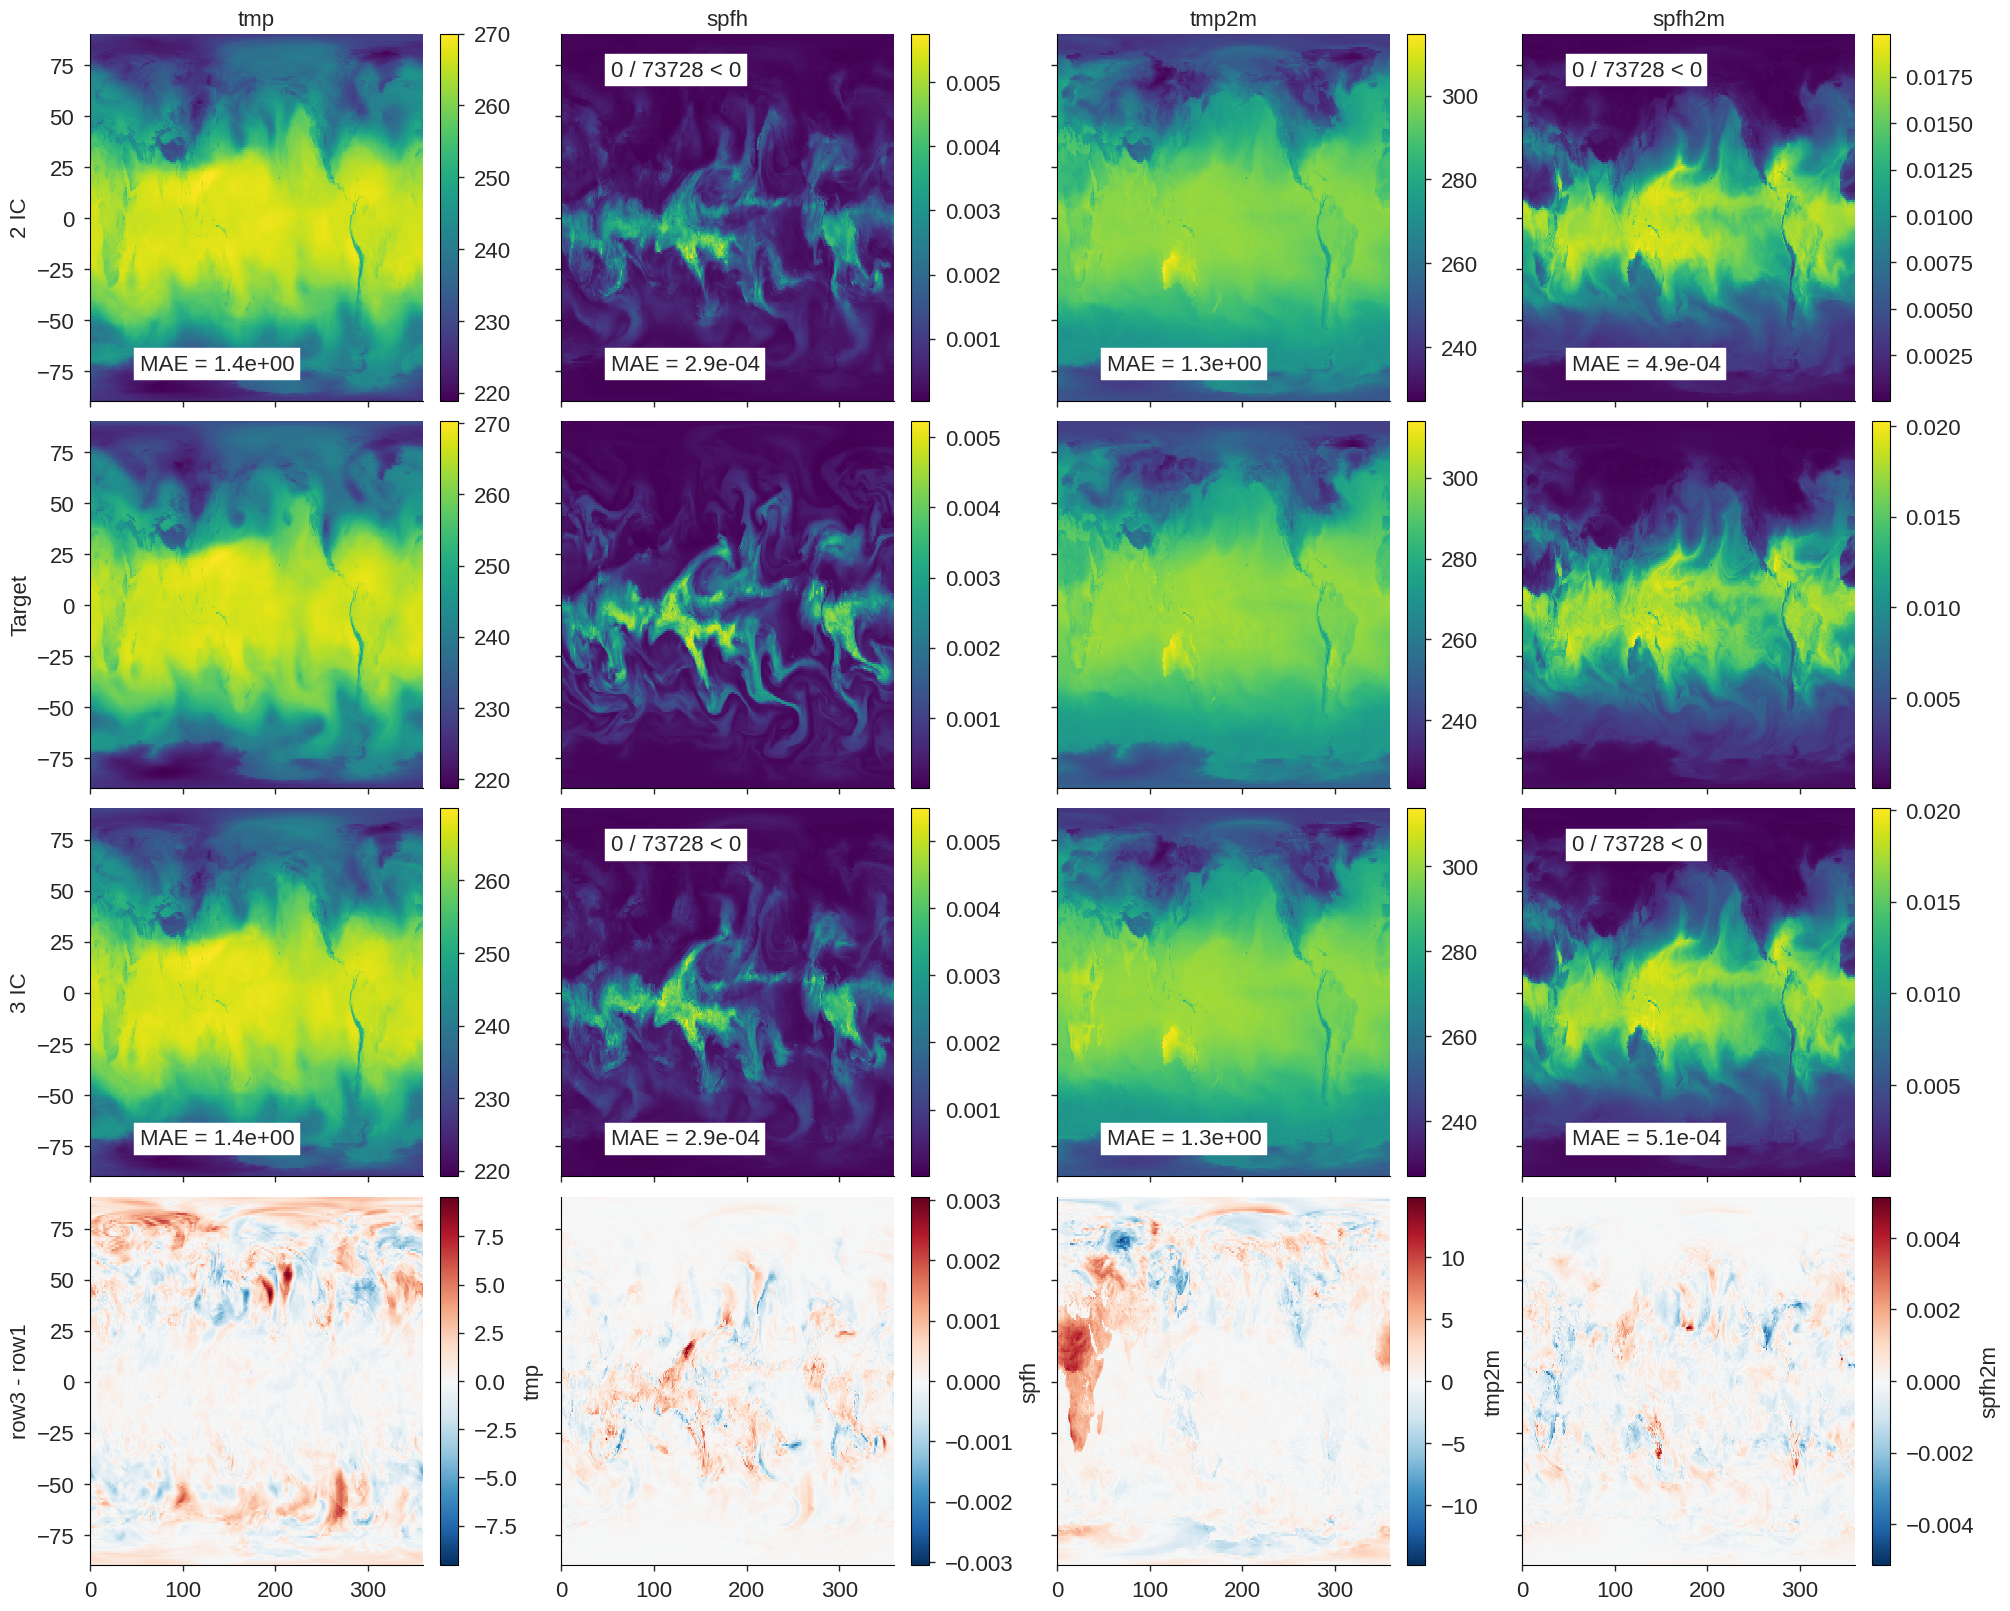

In [9]:
make_plot(["tmp", "spfh", "tmp2m", "spfh2m"]);

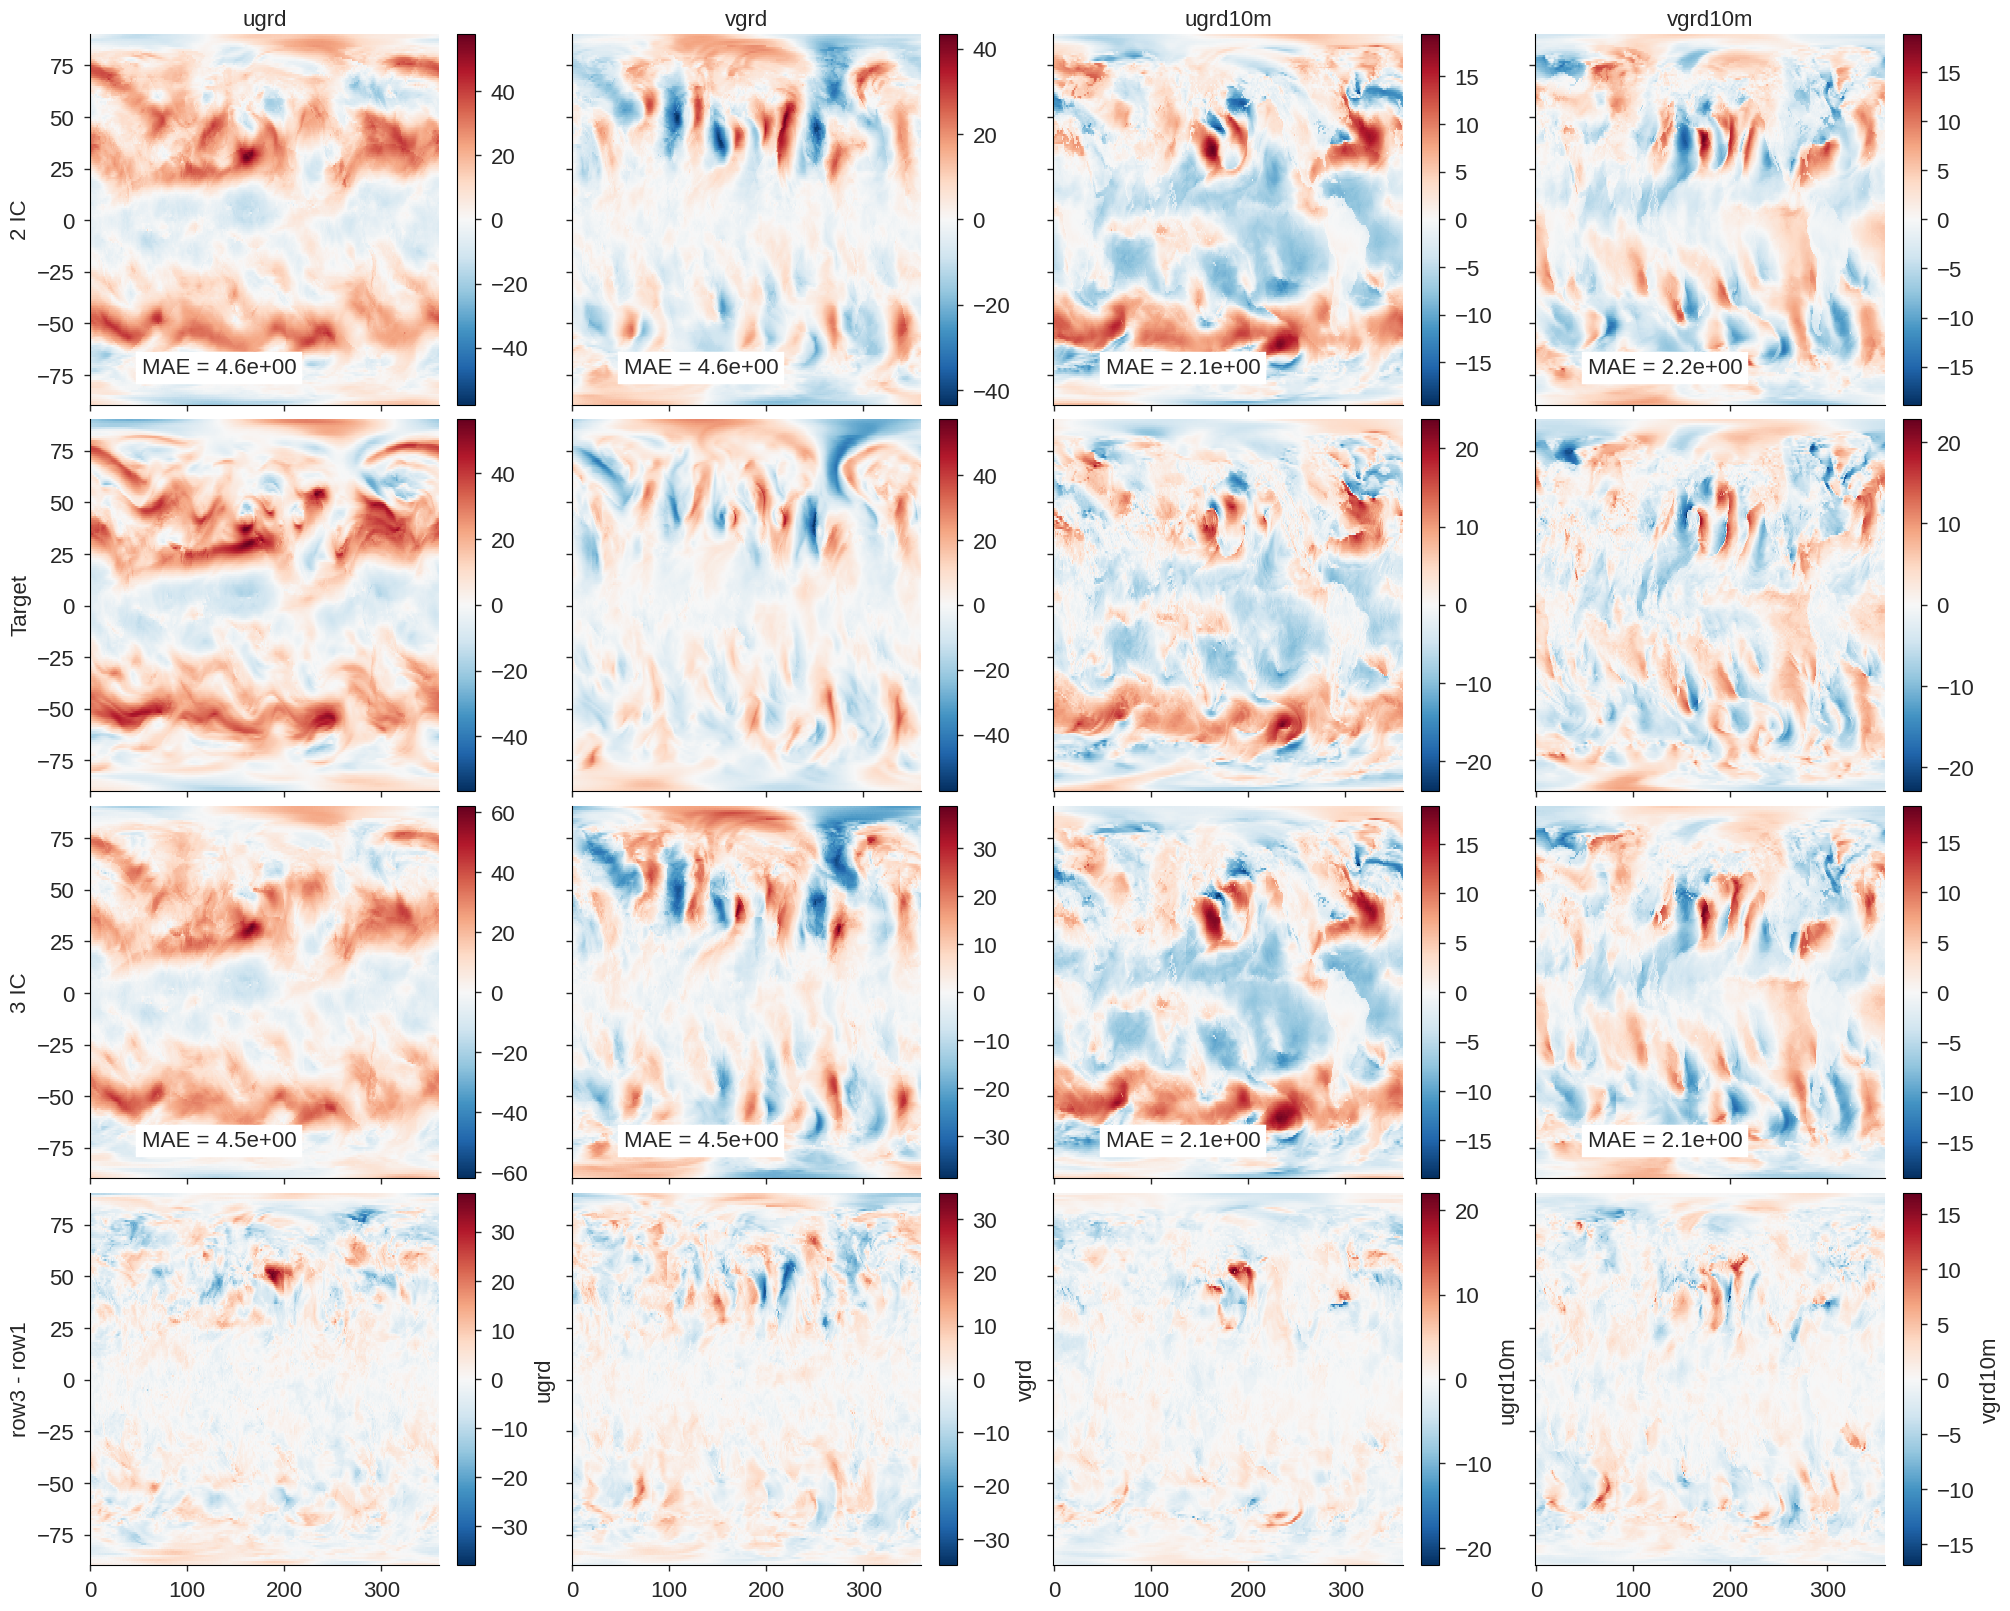

In [10]:
make_plot(["ugrd", "vgrd", "ugrd10m", "vgrd10m"]);

## Plot Error

In [11]:
import seaborn as sns

In [12]:
def plot_error(varlist):
    nrows=1
    ncols = len(varlist)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True)

    ilevel = 2 

    output_transforms = experiments["2 IC"]["emulator"].output_transforms

    for v, ax in zip(varlist, axs):
        for ii, key in enumerate(experiments.keys()):
            p = swap_dims(experiments[key]["predictions"][v])
            t = swap_dims(experiments[key]["targets"][v])
            
            if "level" in p.dims:
                p = p.isel(level=ilevel)
                t = t.isel(level=ilevel)

            if v in output_transforms:
                p = output_transforms[v](p)
                t = output_transforms[v](t)

            plotme = np.abs(p-t).mean(["lat", "lon"]).squeeze()

            sns.lineplot(
                plotme.to_dataframe().reset_index(),
                x="fhr",
                y=v,
                ax=ax,
                color=f"C{ii}",
                errorbar="sd",
                label=key,
                legend=False,
            )
        ax.set(title=v, xticks=list(x for x in range(0, 25, 6)))

    axs[-1].legend(loc="center left", bbox_to_anchor=(1, .5))
    return fig, axs

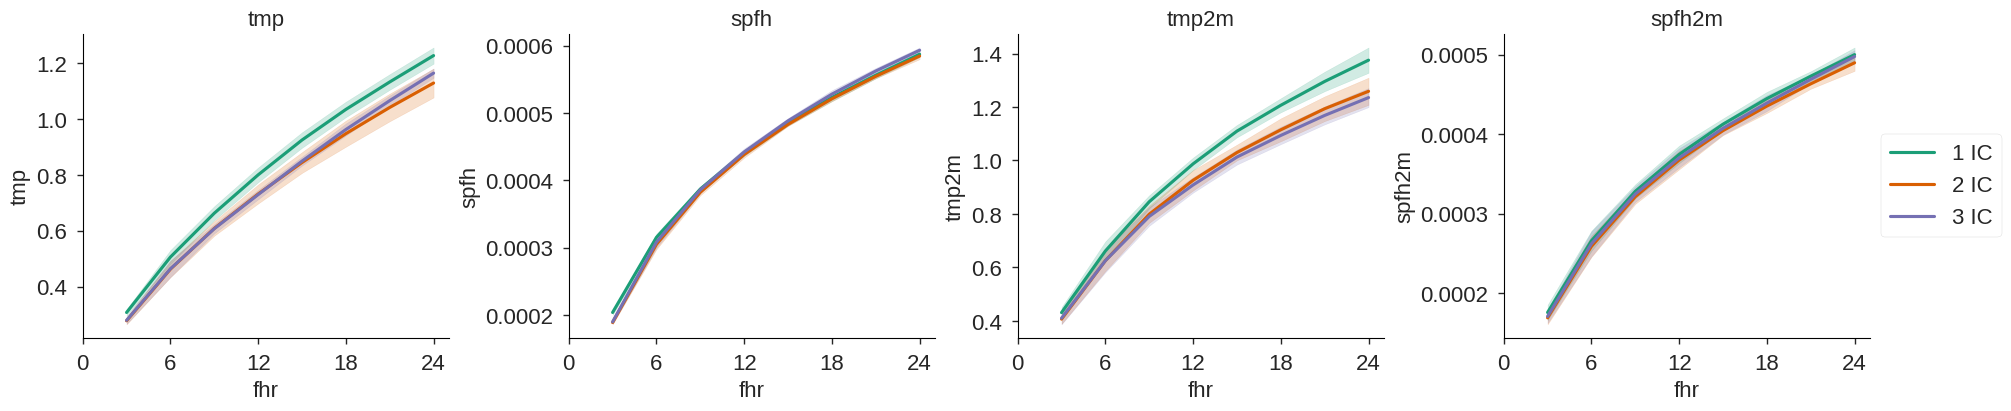

In [13]:
plot_error(["tmp", "spfh", "tmp2m", "spfh2m"]);

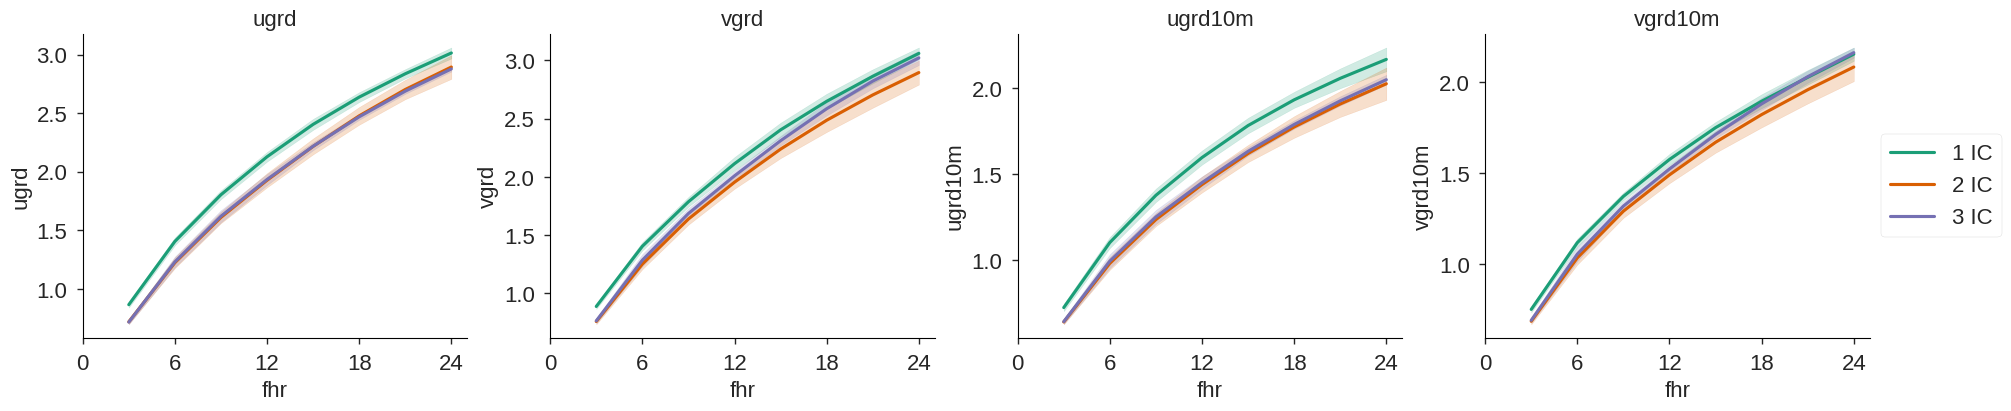

In [14]:
plot_error(["ugrd", "vgrd", "ugrd10m", "vgrd10m"]);

### Spectra

In [15]:
def plot_spectra(vlist):
    ncols = len(vlist)
    fig, axs = plt.subplots(1, len(vlist), figsize=(ncols*5, 4), constrained_layout=True, sharex=True)
    
    ilevel = 0 
    itime = 0
    ilead = -1 
    
    output_transforms = experiments["2 IC"]["emulator"].output_transforms
    
    plotlist = {k : list() for k in vlist}
    for cid, key in enumerate(experiments.keys()):
        
        for v, ax in zip(vlist, axs):
            for xds, ls in zip(
                [experiments[key]["predictions"],
                 experiments[key]["targets"].copy(),
                ],
                ["-", ":"],
            ):
                computer = ZonalEnergySpectrum(v)
                plotme = xds[[v]].isel(time=itime).squeeze()
                plotme = plotme.rename({"lat": "latitude", "lon": "longitude"})
                if "level" in plotme.dims:
                    plotme = plotme.isel(level=ilevel, drop=True)
                plotme = plotme.isel(lead_time=ilead)
                if v in output_transforms:
                    plotme = output_transforms[v](plotme)
    
                plotme = plotme.compute()
                plotme = computer.compute(plotme)
                plotme = plotme.mean("latitude")
                plotme.plot(ax=ax, xscale="log", yscale="log", x="zonal_wavenumber", linestyle=ls, color=f"C{cid}", label=key)
            ax.set(title=v)
    axs[-1].legend(bbox_to_anchor=(1.1, .5), loc="center left")
    return fig, axs


[(0.0038912183413195617, 100.0)]

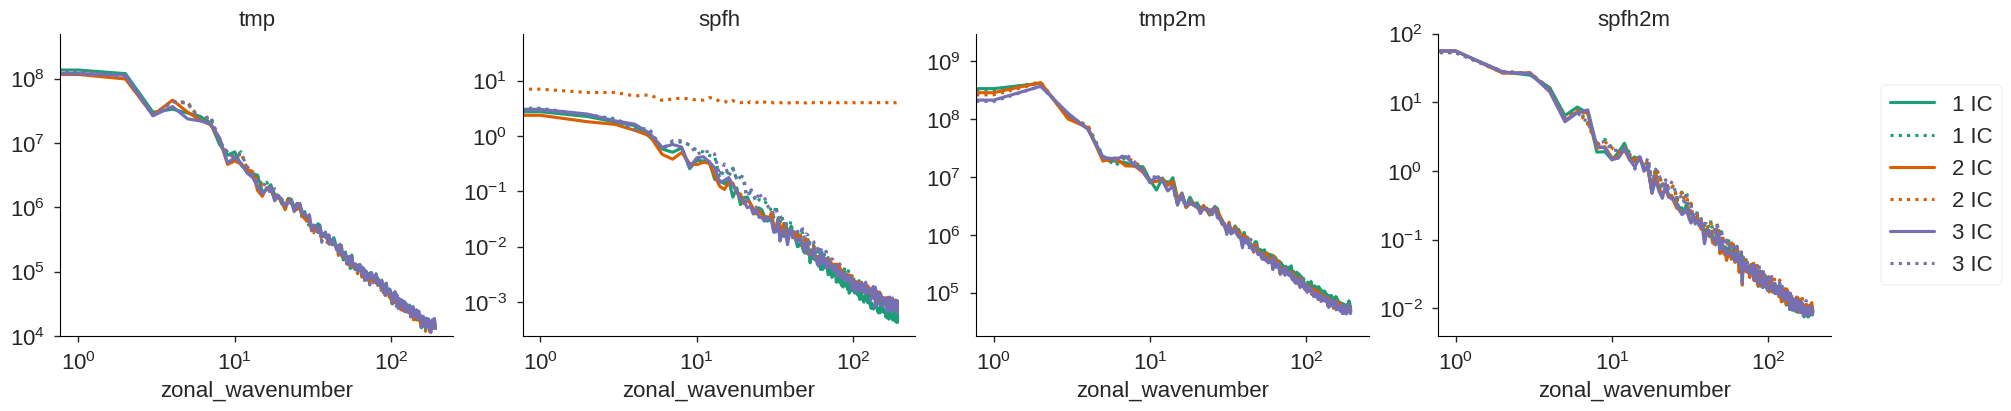

In [16]:
fig, axs = plot_spectra(["tmp", "spfh", "tmp2m", "spfh2m"])
axs[0].set(ylim=(1e4, 5e8))
#axs[1].set(ylim=(None, 1e1))
axs[2].set(ylim=(None, 3e9))
axs[3].set(ylim=(None, 1e2))


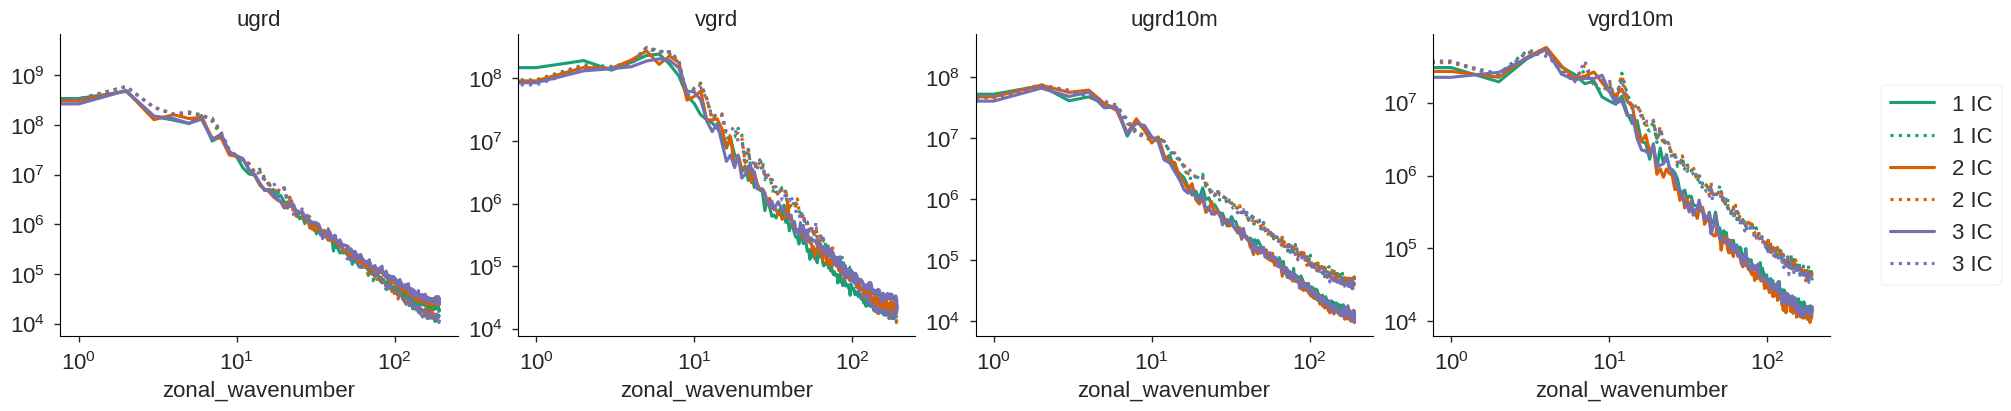

In [17]:
fig, axs = plot_spectra(["ugrd", "vgrd", "ugrd10m", "vgrd10m"])

## Loss


In [18]:
bloss = xr.open_dataset("../tp0/local-output/loss.nc")
sloss = xr.open_dataset("local-output/loss.nc")
tloss = xr.open_dataset("local-output-3ic/loss.nc")

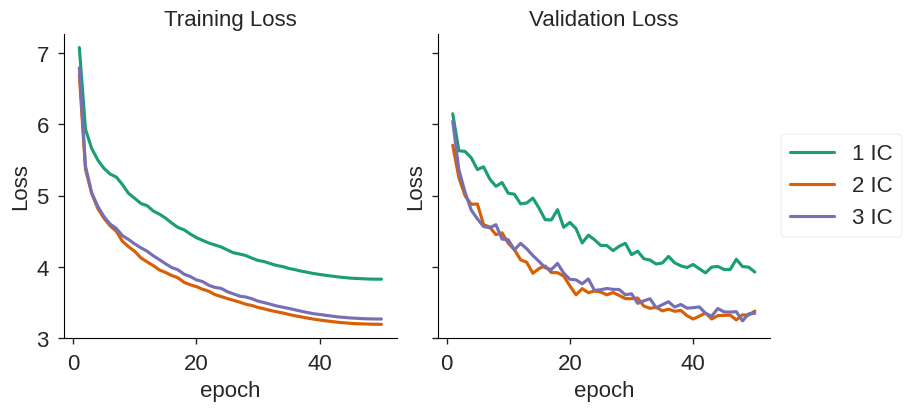

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharey=True)

for key, title, ax in zip(["loss_avg", "loss_valid"], ["Training Loss", "Validation Loss"], axs):
    for xds, label in zip([sloss, bloss, tloss], ["1 IC", "2 IC", "3 IC"]):
        xds[key].plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
    ax.set(title=title, ylabel="Loss" if ax.get_subplotspec().is_first_row() else "")
    
axs[-1].legend(loc="center left", bbox_to_anchor=(1., .5))

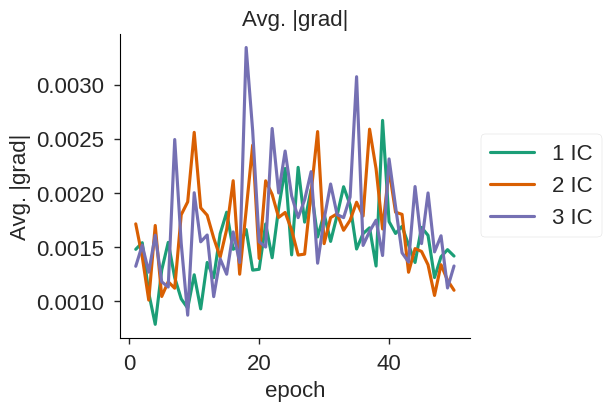

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

key = "mgrad"
title = "Avg. |grad|"

for xds, label in zip([sloss, bloss, tloss], ["1 IC", "2 IC", "3 IC"]):
    plotme = xds[key]
    plotme.plot(ax=ax, label=label if ax.get_subplotspec().is_last_col() else None)
ax.set(title=title, ylabel="Avg. |grad|" if ax.get_subplotspec().is_first_row() else "")
    
ax.legend(loc="center left", bbox_to_anchor=(1., .5))